In [29]:
EPOCHS = 150
IMG_SIZE = 224
BATCH_SIZE = 16

NUM_FEATURES = 2048
MAX_SEQ_LENGTH = 200

video_dir = 'Cattle_Diseases/*/*.mp4'

class_dict = {
            'Bovine Spongiform Encephalopathy' : 0,
            'Healthy' : 1,
            'Heat Stress' : 2,
            'Lameness' : 3,
            'Unknown' : 4,
            }
class_dict_rev = {v: k for k, v in class_dict.items()}

In [30]:
import numpy as np
import pandas as pd
import cv2, glob, os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential

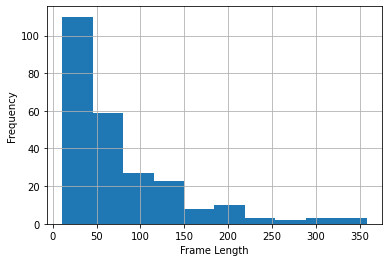

count    248.000000
mean      77.185484
std       65.671415
min       11.000000
25%       33.750000
50%       49.000000
75%       97.000000
max      358.000000
dtype: float64


In [31]:
def frame_length_distribution():
    frame_lengths = []
    for video_path in glob.glob(video_dir):
        vidcap = cv2.VideoCapture(video_path)
        frame_length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) // 5
        frame_lengths.append(frame_length)
        
    frame_dist = pd.Series(frame_lengths)
    frame_dist.hist()
    plt.xlabel('Frame Length')
    plt.ylabel('Frequency')
    plt.savefig('visualization/frame length.png')
    plt.show()
    
    print(frame_dist.describe())


frame_length_distribution()

In [32]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if frame_count % 5 == 0:
                if not ret:
                    break
                frame = crop_center_square(frame)
                frame = cv2.resize(frame, resize)
                frame = frame[:, :, [2, 1, 0]]
                frames.append(frame)

                if len(frames) == max_frames:
                    break

            frame_count += 1
    finally:
        cap.release()
    return np.array(frames)

In [33]:
def build_feature_extractor():
    feature_extractor = tf.keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return tf.keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [34]:
def prepare_all_videos():
    video_paths = glob.glob(video_dir)
    num_samples = len(video_paths)

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    labels = []
    for idx, path in enumerate(video_paths):
        label = path.split('\\')[1]
        labels.append(class_dict[label])

        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        frames = frames[None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
    labels = np.array(labels)

    return (frame_features, frame_masks), labels

In [35]:
def get_sequence_model():
    frame_features_input = tf.keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = tf.keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = tf.keras.layers.GRU(16, return_sequences=True)(
                                                        frame_features_input, 
                                                        mask=mask_input
                                                        )
    x = tf.keras.layers.GRU(8)(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    output = tf.keras.layers.Dense(len(class_dict), activation="softmax")(x)

    rnn_model = tf.keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
                    loss="sparse_categorical_crossentropy", 
                    optimizer="adam", 
                    metrics=["accuracy"]
                    )
    return rnn_model


def run_experiment():
    early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor="loss", 
                                                    patience=8, 
                                                    restore_best_weights=True
                                                    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
                        [data[0], data[1]],
                        labels,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping],
                        )

    seq_model.save('weights/behaviour_classification.h5')
    return history, seq_model

if not os.path.exists('weights/behaviour_classification.h5'):
    data, labels = prepare_all_videos()

    print(f"Frame features in data set: {data[0].shape}")
    print(f"Frame masks in data set: {data[1].shape}")
    history, sequence_model = run_experiment()
else:
    sequence_model = tf.keras.models.load_model('weights/behaviour_classification.h5')
    sequence_model.compile(
                            loss="sparse_categorical_crossentropy", 
                            optimizer="adam", 
                            metrics=["accuracy"]
                            )

Frame features in data set: (248, 200, 2048)
Frame masks in data set: (248, 200)
Epoch 1/150
16/16 [==============================] - 6s 118ms/step - loss: 1.7697 - accuracy: 0.1532
Epoch 2/150
16/16 [==============================] - 2s 117ms/step - loss: 1.6535 - accuracy: 0.1935
Epoch 3/150
16/16 [==============================] - 2s 118ms/step - loss: 1.5995 - accuracy: 0.2621
Epoch 4/150
16/16 [==============================] - 2s 117ms/step - loss: 1.5477 - accuracy: 0.2944
Epoch 5/150
16/16 [==============================] - 2s 116ms/step - loss: 1.4884 - accuracy: 0.3347
Epoch 6/150
16/16 [==============================] - 2s 127ms/step - loss: 1.4320 - accuracy: 0.3871
Epoch 7/150
16/16 [==============================] - 2s 116ms/step - loss: 1.3814 - accuracy: 0.4113
Epoch 8/150
16/16 [==============================] - 2s 116ms/step - loss: 1.3175 - accuracy: 0.4395
Epoch 9/150
16/16 [==============================] - 2s 115ms/step - loss: 1.3070 - accuracy: 0.4315
Epoch 10/1

16/16 [==============================] - 2s 119ms/step - loss: 0.1858 - accuracy: 0.9516
Epoch 81/150
16/16 [==============================] - 2s 119ms/step - loss: 0.1869 - accuracy: 0.9355
Epoch 82/150
16/16 [==============================] - 2s 118ms/step - loss: 0.1513 - accuracy: 0.9597
Epoch 83/150
16/16 [==============================] - 2s 118ms/step - loss: 0.1489 - accuracy: 0.9597
Epoch 84/150
16/16 [==============================] - 2s 120ms/step - loss: 0.1565 - accuracy: 0.9476
Epoch 85/150
16/16 [==============================] - 2s 120ms/step - loss: 0.1563 - accuracy: 0.9476
Epoch 86/150
16/16 [==============================] - 2s 119ms/step - loss: 0.1924 - accuracy: 0.9194
Epoch 87/150
16/16 [==============================] - 2s 118ms/step - loss: 0.1266 - accuracy: 0.9597
Epoch 88/150
16/16 [==============================] - 2s 119ms/step - loss: 0.1445 - accuracy: 0.9556
Epoch 89/150
16/16 [==============================] - 2s 120ms/step - loss: 0.1371 - accuracy: 

In [36]:
sequence_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200, 2048)]  0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 200, 16)      99168       ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 gru_3 (GRU)                    (None, 8)            624         ['gru_2[0][0]']            

In [37]:
def process_single_video(path):
    frames = load_video(path)
    frames = frames[None, ...]

    temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    temp_frame_features = np.zeros(
        shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            temp_frame_features[i, j, :] = feature_extractor.predict(
                batch[None, j, :]
            )
        temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
    return (temp_frame_features.squeeze(), temp_frame_mask.squeeze())

In [38]:
def video_classification_inference(path):
    data = process_single_video(path)
    frame_features = data[0][None, ...]
    frame_masks = data[1][None, ...]
    predictions = sequence_model.predict([frame_features, frame_masks])
    predictions = np.argmax(predictions, axis=-1)
    return class_dict_rev[predictions[0]]

In [39]:
path = 'Cattle_Diseases/Bovine Spongiform Encephalopathy/aggressive1.mp4'
video_classification_inference(path)

'Bovine Spongiform Encephalopathy'

In [41]:
path = 'Cattle_Diseases/Unknown/bird3.mp4'
video_classification_inference(path)

'Unknown'

In [40]:
path = 'Cattle_Diseases/Healthy/healthy_walking4.mp4'
video_classification_inference(path)

'Healthy'

In [42]:
path = 'Cattle_Diseases/Lameness/lameness_1.mp4'
video_classification_inference(path)

'Lameness'

In [43]:
path = 'Cattle_Diseases/Healthy/healthy_eating.mp4'
video_classification_inference(path)

'Lameness'